In [88]:
import numpy as np 
import FlowCytometryTools
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import FCPlate
from FlowCytometryTools import ThresholdGate, PolyGate
import matplotlib.pyplot as plt
import scipy as sp
import scipy.special
import seaborn as sns
import pandas as pd

FSCHgateupper = ThresholdGate(6550.0, ['FSC-H'], region='below')
FSCHgatelower = ThresholdGate(5100.0, ['FSC-H'], region='above')
SSCHgatelower = ThresholdGate(4800.0, ['SSC-H'], region='above') 
SSCHgateupper = ThresholdGate(5600.0, ['SSC-H'], region='below')
scatter_gates = FSCHgateupper & FSCHgatelower & SSCHgatelower & SSCHgateupper


bfp_threshold = 7850
yfp_threshold = 6500

days = list(range(2))
plate_num = list(range(1,4))
plates = {}

for day in days:
    list_plates = []
    datadir = '/Users/kristenlok/Desktop/2.8.22_monoculture_flucts/D{}/'.format(str(day))
    if day == 1:
        for p in plate_num:
            datadir = '/Users/kristenlok/Desktop/2.8.22_monoculture_flucts/D1/p{}/'.format(str(p))
            plate = FCPlate.from_dir(ID='96-well', path=datadir, parser='name')
            plate_transformed = plate.transform('hlog', channels=['BFP-H','YFP-H'], b=100.0).transform('hlog', channels=['FSC-H','SSC-H'], b=10.0**2).gate(scatter_gates)
            list_plates.append(plate_transformed)
    else:
        plate = FCPlate.from_dir(ID='96-well', path=datadir, parser='name')
        plate_transformed = plate.transform('hlog', channels=['BFP-H','YFP-H'], b=100.0).transform('hlog', channels=['FSC-H','SSC-H'], b=10.0**2).gate(scatter_gates)
        list_plates.append(plate_transformed) 
    plates[day] = list_plates
    
def f1_expectation(theta,f1obs_data,f2obs_data,nmax=100):
    f1,lam = theta
    f2=1-f1
    f1obs=0
    f2obs=0
    for k in range(1,nmax):
        f1obs+=((f1*lam)**k)/scipy.special.factorial(k)/(np.exp(lam)-1)
        f2obs+=((f2*lam)**k)/scipy.special.factorial(k)/(np.exp(lam)-1)
    return f1obs-f1obs_data, f2obs-f2obs_data


def get_bfp_freq(data):
    bfp_pos = data['BFP-H']>bfp_threshold
    yfp_pos = data['YFP-H']>yfp_threshold
    bfp_neg = data['BFP-H']<bfp_threshold
    yfp_neg = data['YFP-H']<yfp_threshold

    bfp = len(data[bfp_pos & yfp_neg])
    yfp = len(data[yfp_pos & bfp_neg])
    dp = len(data[bfp_pos & yfp_pos])
    Q = bfp + yfp + dp
    func = lambda theta: f1_expectation(theta,bfp/Q,yfp/Q)
    res = sp.optimize.root(func, [bfp/Q, 0.5])

    bfp_mean = np.float(data[bfp_pos & yfp_neg]['BFP-H'].mean())
    yfp_mean = np.float(data[yfp_pos & bfp_neg]['YFP-H'].mean())
    return res.x, Q, bfp_mean, yfp_mean

In [90]:
df_temp = pd.read_csv('/Users/kristenlok/Desktop/Indoor_Thermometer.csv')
df_temp.head()

,Timestamp for sample frequency every 1 min min,Temperature_Celsius(calibrated +3 deg C),Relative_Humidity
0,2022-02-07 08:47:00,36.9,17.4
1,2022-02-07 08:48:00,36.9,17.4
2,2022-02-07 08:49:00,36.9,17.5
3,2022-02-07 08:50:00,36.9,17.5
4,2022-02-07 08:51:00,36.9,17.5


In [4]:
b_data=[]

cols = [1,3]
rows = ['A','B','C','D','E']

for day in days:
    for row in rows:
        for col in cols:
            for plate in plates[day]:
                well = row + str(col)
                well_sort = str(col) + row
                try:
                    res,Q,bfp,yfp = get_bfp_freq(plate[well].data)
                except:
                    continue
                if day == 0 and col == 1:
                    group = "A-G1-3"
                if day == 0 and col == 3:  
                    group = "A-E4-6"
                if day == 1 and plates[day].index(plate)+1 == 1:
                    group = "A-G1-3"
                if day == 1 and plates[day].index(plate)+1 == 2:
                    if col == 1:
                        group = "A-G1-3" 
                    if col == 3:
                        group = "A-E4-6"
                if day == 1 and plates[day].index(plate)+1 == 3:
                    group = "A-E4-6"
                    
                b_data.append({
                    'day':day,
                    'plate':plates[day].index(plate)+1,
                    'well':well,
                    'sort by well': well_sort,
                    'group': group,
                    'S freq': res[0],
                    'lambda': res[1],
                    'total count':Q,
                    'corrected total count': Q*res[1]/(1-np.exp(-res[1])),
                    'BFP':bfp,
                    'YFP':yfp,
                })     
            
df = pd.DataFrame(b_data)
df.sort_values(['day','plate', 'sort by well'])

,day,plate,well,sort by well,group,S freq,lambda,total count,corrected total count,BFP,YFP
0,0,1,A1,1A,A-G1-3,0.361703,1.248582,24595,43064.597766,8052.548828,7395.244141
2,0,1,B1,1B,A-G1-3,0.514060,1.198807,24108,41378.763195,8320.111328,7221.735352
4,0,1,C1,1C,A-G1-3,0.344431,0.967100,20395,31822.346850,8048.381836,7569.718750
6,0,1,D1,1D,A-G1-3,0.680680,0.863907,18642,27839.742704,8338.569336,7544.287109
8,0,1,E1,1E,A-G1-3,0.530767,1.513323,18483,35868.084255,8311.609375,7556.173340
1,0,1,A3,3A,A-E4-6,0.293018,1.255546,24985,43868.982154,8033.054199,7390.643066
3,0,1,B3,3B,A-E4-6,0.516447,1.336770,20053,36356.959762,8309.122070,7046.725098
5,0,1,C3,3C,A-E4-6,0.396271,1.063613,21790,35394.546457,8062.901855,7573.229980
7,0,1,D3,3D,A-E4-6,0.076539,0.775271,14962,21503.808819,8757.442383,7552.587402
9,0,1,E3,3E,A-E4-6,0.968020,1.383037,22788,42067.942542,8368.207031,7869.333496


In [5]:
def get_freqncount(df, days, group, row): #where rowA=229+231, rowB = 246+247, rowC = 248+249, rowD=245+246, rowE=246+249
    freq_dict = {}
    count_dict = {}
    freq_list = []
    count_list = []
    for day in days:
        df_day = df.loc[df['day'] == day]
        freq_rep = []
        count_rep = []
        for i in range(len(df_day)):
            if df_day.iloc[i,4] == group and df_day.iloc[i,2][0] == row:
                freq = df_day.iloc[i,5] #S_freq index = 5
                freq_rep.append(freq)
                count = df_day.iloc[i,8] #corrected total count index = 8
                count_rep.append(count)
        freq_list.append(freq_rep)
        count_list.append(count_rep)
    freq_dict[group + "_" + row] = freq_list
    count_dict[group + "_" + row] = count_list
    return freq_dict, count_dict
            

In [7]:
groups = ["A-G1-3","A-E4-6"]
rows = ["A","B","C","D","E"]

all_freqs = []
all_counts = []
for group in groups:
    for row in rows:
        freq, count = get_freqncount(df, days, group, row)
        all_freqs.append(freq)
        all_counts.append(count)
        
print(all_freqs)
print(all_counts)

[{'A-G1-3_A': [[0.36170285353412845], [0.39161397782059265, 0.30820181019487247, 0.3171550278235587]]}, {'A-G1-3_B': [[0.5140601669461241], [0.5358305193606422, 0.5866199998498253, 0.5633794295664278]]}, {'A-G1-3_C': [[0.3444312426309914], [0.3919077096159149, 0.38394520709492075, 0.4147194320884624]]}, {'A-G1-3_D': [[0.6806796267830059], [0.6145599684742651, 0.5923191812337789, 0.6329868880665337]]}, {'A-G1-3_E': [[0.5307665412074231], [0.5308892125500155, 0.5521316395566442, 0.6115761207639301]]}, {'A-E4-6_A': [[0.2930180519392695], [0.2730600429233733, 0.2399983761473625, 0.29409454217875053]]}, {'A-E4-6_B': [[0.516446891936119], [0.5552288583129742, 0.5372254837135355, 0.5434476721180413]]}, {'A-E4-6_C': [[0.39627133651163887], [0.35380184520641006, 0.33123391366251054, 0.3952035526067293]]}, {'A-E4-6_D': [[0.0765390144755014], [0.07099114304635751, 0.06285085144355777, 0.07467784335081679]]}, {'A-E4-6_E': [[0.9680203707472642], [0.9767158797845326, 0.9752276739731939, 0.9706761747

In [42]:
#draft function (ignore)
def plot_freqs(group, all_freqs, all_counts):
    days = [0,1]
    for dictionary1 in all_freqs, all_counts):
        if list(dictionary1.keys())[0] == group:
            for value1,value2 in zip(dictionary1.values(),dictionary2.values()):
                frq_day0 = value1[0][0]
                freq_vals = []
                freq_vals.append(frq_day0)
                frq_day1 = np.mean(value1[1])
                print(frq_day1)
                freq_vals.append(frq_day1)
                
                count_day0 = value2[0][0]
                count_vals = []
                count_vals.append(count_day0)
                count_day1 = np.mean(value2[1])
                print(count_day1)
                count_vals.append(count_day1)
                
                plt.plot(days, freq_vals, label="Frequency")
                plt.plot(days, count_vals, label="Corrected Counts")
                
                plt.title(list(dictionary.keys())[0])
                plt.xlabel("Days")
                plt.ylabel("BFP Frequency")
                plt.xticks(np.arange(0,len(days),1))
                plt.legend()


In [80]:
def plot_freqs(group, all_freqs):
    days = [0,1]
    for dictionary in all_freqs:
        if list(dictionary.keys())[0] == group:
            for value in dictionary.values():
                frq_day0 = value[0][0]
                y_vals_mean = []
                y_vals_mean.append(frq_day0)
                frq_day1 = np.mean(value[1])
                y_vals_mean.append(frq_day1)
                plt.plot(days, y_vals_mean, label = "Average")
                for i in range(0,3):
                    y_vals = []
                    y_vals.append(frq_day0)
                    y_vals.append(value[1][i])
                    print(y_vals)
                    plt.plot(days, y_vals, label = "Replicates")
                    plt.title(list(dictionary.keys())[0] + " Frequency")
                    plt.xlabel("Days")
                    plt.ylabel("BFP freq")
                    plt.xticks(np.arange(0,len(days),1))
                    plt.legend()
    plt.show()
                    
                    
def plot_counts(group, all_counts):
    days = [0,1]
    for dictionary in all_counts:
        if list(dictionary.keys())[0] == group:
            for value in dictionary.values():
                count_day0 = value[0][0]
                y_vals_mean = []
                y_vals_mean.append(count_day0)
                count_day1 = np.mean(value[1])
                y_vals_mean.append(count_day1)
                plt.plot(days, y_vals_mean, label = "Average")
                for i in range(0,3):
                    y_vals = []
                    y_vals.append(count_day0)
                    y_vals.append(value[1][i])
                    print(y_vals)
                    plt.plot(days, y_vals, label = "Replicates")
                    plt.title(list(dictionary.keys())[0] + " Counts")
                    plt.xlabel("Days")
                    plt.ylabel("Corrected count")
                    plt.xticks(np.arange(0,len(days),1))
                    plt.legend()
    plt.show()

[0.36170285353412845, 0.39161397782059265]
[0.36170285353412845, 0.30820181019487247]
[0.36170285353412845, 0.3171550278235587]


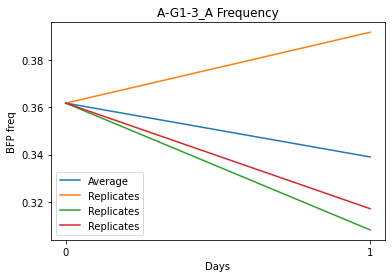

[43064.597766203326, 46890.238368566104]
[43064.597766203326, 49658.653980192066]
[43064.597766203326, 43253.59654301082]


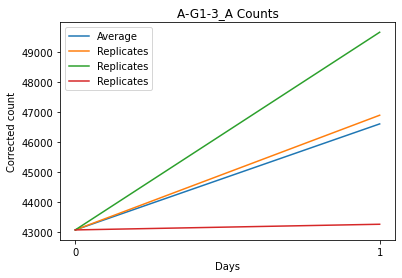

In [81]:
plot_freqs("A-G1-3_A", all_freqs)
plot_counts("A-G1-3_A", all_counts)

['A-G1-3_A', 'A-G1-3_B', 'A-G1-3_C', 'A-G1-3_D', 'A-G1-3_E', 'A-E4-6_A', 'A-E4-6_B', 'A-E4-6_C', 'A-E4-6_D', 'A-E4-6_E']
[0.36170285353412845, 0.39161397782059265]
[0.36170285353412845, 0.30820181019487247]
[0.36170285353412845, 0.3171550278235587]


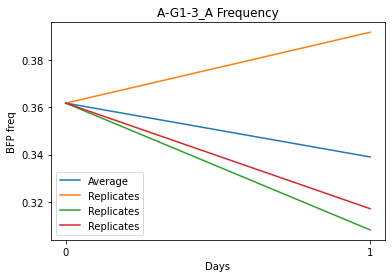

[43064.597766203326, 46890.238368566104]
[43064.597766203326, 49658.653980192066]
[43064.597766203326, 43253.59654301082]


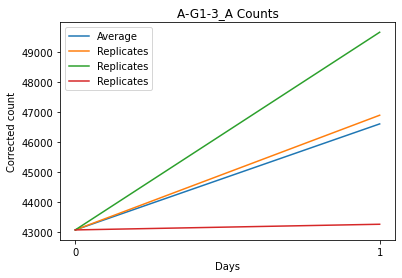

[0.5140601669461241, 0.5358305193606422]
[0.5140601669461241, 0.5866199998498253]
[0.5140601669461241, 0.5633794295664278]


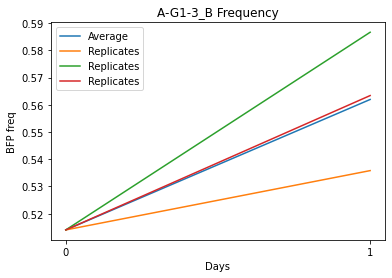

[41378.76319491346, 42238.66894250397]
[41378.76319491346, 47686.63743706253]
[41378.76319491346, 41699.028207529635]


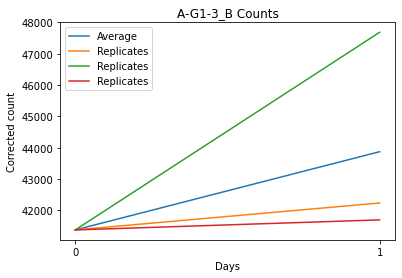

[0.3444312426309914, 0.3919077096159149]
[0.3444312426309914, 0.38394520709492075]
[0.3444312426309914, 0.4147194320884624]


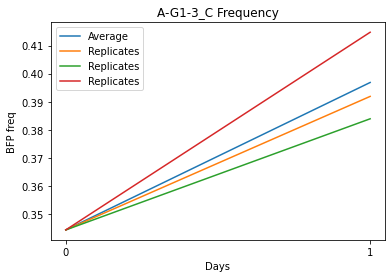

[31822.34685011159, 31880.142577021776]
[31822.34685011159, 33300.90628370475]
[31822.34685011159, 29170.877915594076]


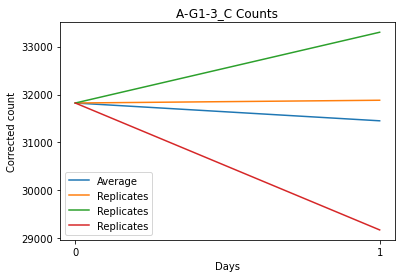

[0.6806796267830059, 0.6145599684742651]
[0.6806796267830059, 0.5923191812337789]
[0.6806796267830059, 0.6329868880665337]


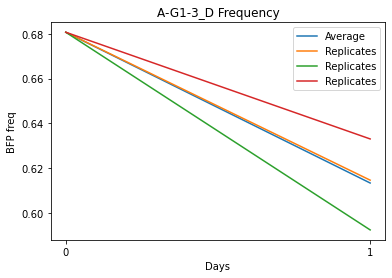

[27839.74270421796, 25517.11680022731]
[27839.74270421796, 38385.28127638297]
[27839.74270421796, 29991.001592671302]


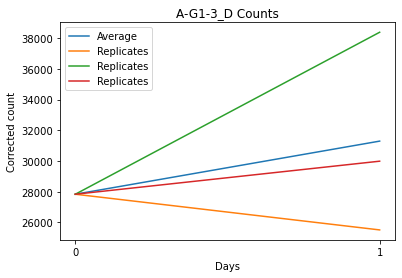

[0.5307665412074231, 0.5308892125500155]
[0.5307665412074231, 0.5521316395566442]
[0.5307665412074231, 0.6115761207639301]


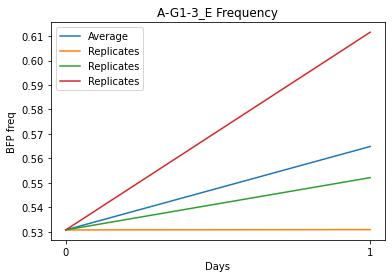

[35868.08425461762, 43185.695026193804]
[35868.08425461762, 48496.34177397778]
[35868.08425461762, 39787.7679100871]


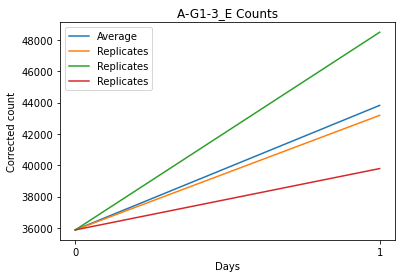

[0.2930180519392695, 0.2730600429233733]
[0.2930180519392695, 0.2399983761473625]
[0.2930180519392695, 0.29409454217875053]


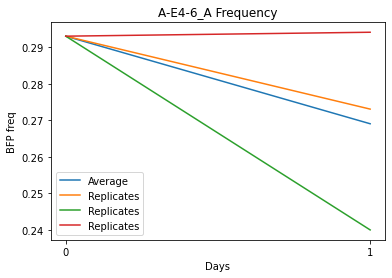

[43868.98215357203, 50017.91039100116]
[43868.98215357203, 43537.755543127896]
[43868.98215357203, 63984.88993600791]


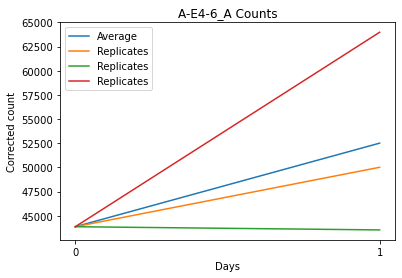

[0.516446891936119, 0.5552288583129742]
[0.516446891936119, 0.5372254837135355]
[0.516446891936119, 0.5434476721180413]


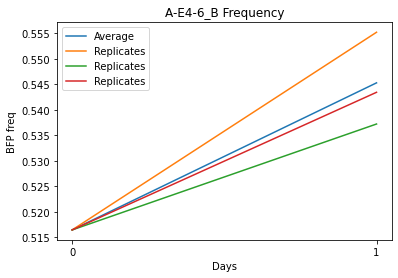

[36356.95976243887, 47208.48971070526]
[36356.95976243887, 53302.797792173216]
[36356.95976243887, 47593.60488691065]


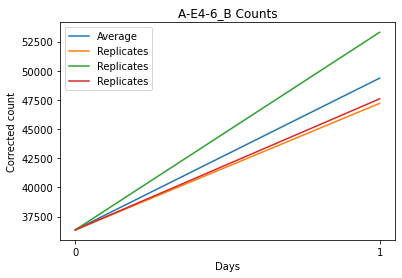

[0.39627133651163887, 0.35380184520641006]
[0.39627133651163887, 0.33123391366251054]
[0.39627133651163887, 0.3952035526067293]


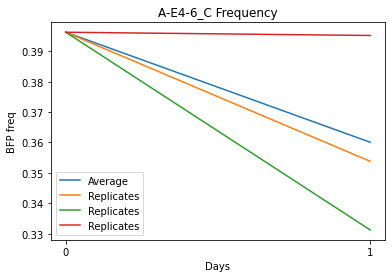

[35394.54645700311, 29080.01986599613]
[35394.54645700311, 33589.48997473844]
[35394.54645700311, 30948.381581460493]


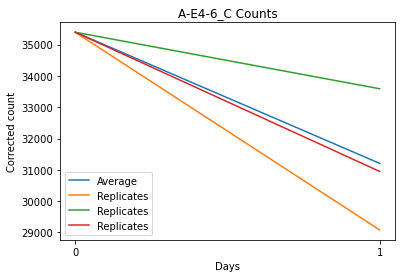

[0.0765390144755014, 0.07099114304635751]
[0.0765390144755014, 0.06285085144355777]
[0.0765390144755014, 0.07467784335081679]


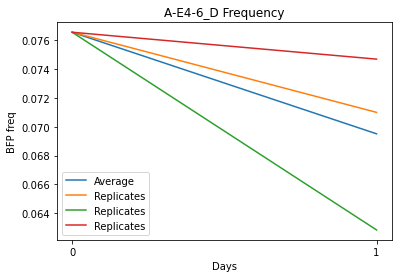

[21503.808819468828, 15515.85796166153]
[21503.808819468828, 29730.60063467377]
[21503.808819468828, 21570.081081833814]


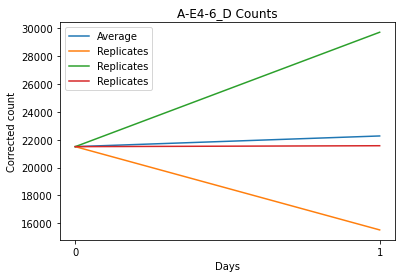

[0.9680203707472642, 0.9767158797845326]
[0.9680203707472642, 0.9752276739731939]
[0.9680203707472642, 0.9706761747000049]


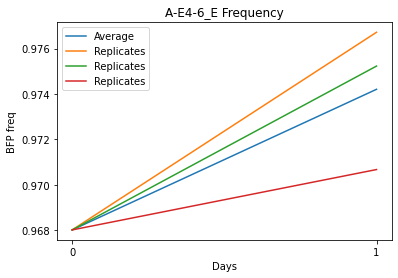

[42067.942542071694, 41331.759452296814]
[42067.942542071694, 41123.84646689942]
[42067.942542071694, 36889.792417567136]


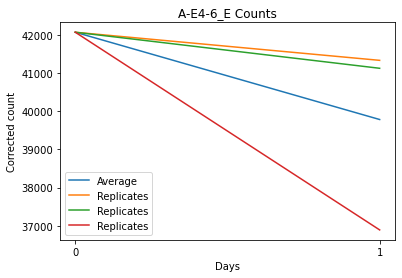

In [86]:
keys = []
for dictionary in all_freqs:
    keys.append(list(dictionary.keys())[0])
print(keys)

for key in keys:
    plot_freqs(key, all_freqs)
    plot_counts(key, all_counts)